In [1]:
import numpy as np
from matplotlib import pyplot as plt
import PIL as PIL

In [2]:
def CalculateColorMap(Image):
    
#Initialize matrix having same dimensions as image; to be used later as index map/data matrix
    print(Image.size[0], Image.size[1])
    
    height, width = Image.size[0], Image.size[1]
    Datamatrix = np.eye(height, width);
    
    print(Datamatrix.shape[0], Datamatrix.shape[1])
    
#Preparing empty dictionary with values starting at 1
    colorMap = {}
    colorIndex = 1
    
    replicated = False
    
#Iterate on all pixels in the image
    for i in range(0, height):
        for j in range(0, width):
            
#Obtain RGB vector from each pixel (for inserting as a key to the color map)
            r,g,b = Image.getpixel((i,j))
            
#Special case for very first pixel, in which color map is still empty
            if(i == 0 and j == 0):
                
#Insert entry in color map containing RGB values stored in tuple form for the key and
#index of the color in the color map using the counter at line 8
                colorMap.update({(r, g, b): colorIndex})
                
#Color inserted in color map must be referenced by the pixel we're currently on
                Datamatrix[i][j] = colorIndex
                
#Color map is no longer empty, must check if the pixel we're on references a color that already exists
#in the color map
            else:
#To check if the color of the pixel is present or not, must loop on color map, comparing color of the pixel
#to all colors in the map. If found, no entry is added to the color map but the data matrix/index map is updated
#with the color's index
                rgbtuple = (r, g, b)
                replicated = False
                if (rgbtuple in colorMap):
                    replicated = True
                    Datamatrix[i][j] = colorMap.get(rgbtuple)
#If color is new to the color map, increment the current index and create a new entry. The datamatrix is also
#updated accordingly
                if(replicated == False):
                    colorIndex += 1
                    colorMap.update({(r, g, b) : colorIndex})
                    Datamatrix[i][j] = colorIndex
                    
    return Datamatrix, colorMap

In [3]:
def QuantizationLevels(colorMap, diff):
    
    # Initializing color map for storing deleted colors and 
    deletedColors = {}
    
    # Reversed color map just to ease access
    inv_Map = ReverseColorMap(colorMap)
    
    # The idea is to compute a range at each pixel using the diff argument, at each pixel. Then loop on the rest
    # of the map, check all r, g, and b components to see if they're in range. If so, they are removed from
    # the color map and inserted with the deleted colors
    
    for i in list(inv_Map.keys()):
        if (inv_Map.get(i) != None):
            
            # Here we compute a range at each pixel by subtracting and adding the diff argument to each component
            # in the RGB vector
            
            UpperBound_r = inv_Map.get(i)[0] + diff
            UpperBound_g = inv_Map.get(i)[1] + diff
            UpperBound_b = inv_Map.get(i)[2] + diff
            
            LowerBound_r = inv_Map.get(i)[0] - diff
            LowerBound_g = inv_Map.get(i)[1] - diff
            LowerBound_b = inv_Map.get(i)[2] - diff
            
            # This is the part where we loop on all the other colors to check if they're in range and take
            # action accordingly
            
            #The list typecast is used to prevent an error from changing the size of a dictionary 
            # during iteration
            for j in list(inv_Map.keys()):
                
                # This check is just to make sure that when we're looping, we don't accidently remove the color
                # at which the range was computed
                if (j == i):
                    j+=1
                
                else:
                    # Obtain the r,g, and b components from the current entry in the color map.
                    # Check if they're within range. If so, delete them from the original
                    # color map, and insert a record in the color map containing deleted colors, 
                    # with the entry/record format being 
                    # {index of removed color: index of color from which range was computed}
                    
                    r, g, b = inv_Map.get(j)[0], inv_Map.get(j)[1], inv_Map.get(j)[2]
                    if ((UpperBound_r >= r >= LowerBound_r) and (UpperBound_g >= g >= LowerBound_g) and (UpperBound_b >= b >= LowerBound_b)):
                    
                        deletedColors.update({j:i})
                        del inv_Map[j]
                    
    outputMap = {v: k for k, v in inv_Map.items()}
    return deletedColors, outputMap
                    
                    
                    

In [4]:
def AdjustIndex(IndexMap, RemovedColors):
    
    height, width = IndexMap.shape[0], IndexMap.shape[1]
    # The idea is to loop on all the cells in the index map/data matrix. At every cell, check if the index
    # is present in the dictionary 'RemovedColors'. If so, change the value in the cell to the index
    # of the color that replaced the old color
    
    for i in range(0, height):
        for j in range(0, width):
            currentIndex = IndexMap[i][j]
            
            # If the index in the cell is present in the removed colors, then the index is changed to
            # to that of the index which replaced the old color using .get(key)
            
            if currentIndex in RemovedColors:
                IndexMap[i][j] = RemovedColors.get(currentIndex)
                
    return IndexMap

In [5]:
def ReverseColorMap(newColorMap):
    
    # Simply loop on the keys and values of the dictionary and assign the key to the value,
    # and the value to the key for each item/entry
    
    inv_Map = {v: k for k, v in newColorMap.items()}
    return inv_Map

In [6]:
def ColorMapToImage(Datamatrix, colorMap):
  
  height, width = Datamatrix.shape[0], Datamatrix.shape[1]
  # Reverse the color map for ease of access
  inv_map = ReverseColorMap(colorMap)
  
  # Initialize an empty RGB image having the same dimensions as our index map/data matrix
  Output = PIL.Image.new("RGB", (height, width))
    
    # The idea is to loop on each cell in the index map/data matrix and use the index in the cell
    # to get the color value from the color map
    
  for i in range(0, height):
    for j in range(0, width):
      index = Datamatrix[i][j]
      
      # Obtain r, g, and b components from color map using the index from the index map/data matrix
      # as our key
    
      r = inv_map.get(index)[0]
      g = inv_map.get(index)[1]
      b = inv_map.get(index)[2]
        
      # After obtaining them, assign the color to the current pixel in our output image
    
      Output.putpixel((i, j), (r, g, b))
        
  return Output

In [7]:
InputImage = PIL.Image.open('Test Image.jpg')

In [8]:
InputImage = InputImage.convert('RGB')

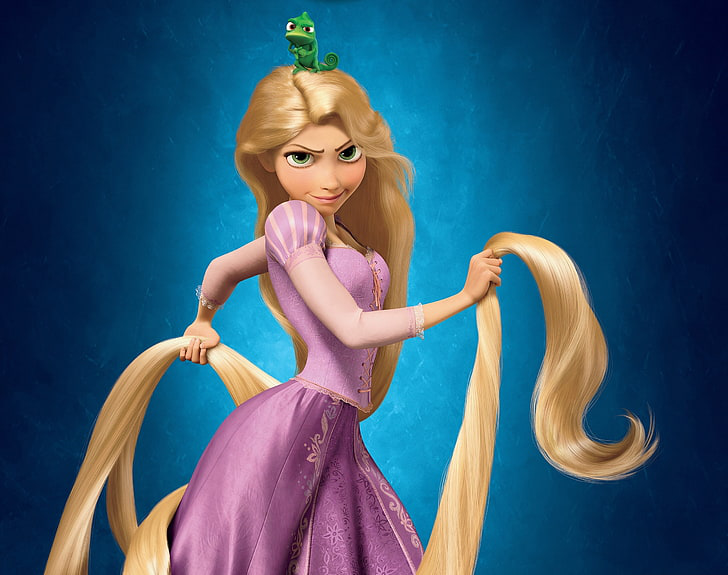

In [9]:
InputImage

# Observation Before Quantization:

# High quality image with various colors, background appears to consist of several shades of blue
# Dress consists of mostly pink and purple colors, red and blue values may higher in this region
# Hair introduces yellow/gold shades into the image, so red and green values ay be greater than blue in those
# areas

In [10]:
DataMatrix, colorMap = CalculateColorMap(InputImage)

728 575
728 575


In [11]:
print("Index Map: ", DataMatrix, "\n")
print("Color Map: ", colorMap)

Index Map:  [[1.0000e+00 1.0000e+00 1.0000e+00 ... 7.9000e+01 7.9000e+01 7.9000e+01]
 [1.0000e+00 1.0000e+00 1.0000e+00 ... 7.9000e+01 9.1000e+01 9.1000e+01]
 [1.0000e+00 1.0000e+00 1.0000e+00 ... 9.9000e+01 9.9000e+01 9.9000e+01]
 ...
 [6.7645e+04 6.7645e+04 6.7645e+04 ... 4.2000e+01 1.1300e+02 2.0000e+01]
 [6.7645e+04 6.7645e+04 6.7645e+04 ... 4.2000e+01 1.1300e+02 2.0000e+01]
 [6.7645e+04 6.7645e+04 6.7645e+04 ... 4.2000e+01 1.1300e+02 2.0000e+01]] 

Color Map:  {(2, 10, 49): 1, (1, 9, 48): 2, (3, 11, 50): 3, (2, 11, 50): 4, (1, 10, 49): 5, (3, 12, 51): 6, (0, 12, 50): 7, (1, 13, 51): 8, (0, 14, 51): 9, (2, 18, 54): 10, (2, 16, 53): 11, (1, 17, 53): 12, (2, 18, 52): 13, (2, 17, 56): 14, (0, 18, 56): 15, (3, 18, 57): 16, (3, 19, 55): 17, (1, 19, 57): 18, (0, 18, 54): 19, (4, 20, 56): 20, (0, 16, 52): 21, (0, 15, 51): 22, (1, 15, 52): 23, (3, 15, 53): 24, (3, 17, 54): 25, (0, 13, 50): 26, (3, 17, 52): 27, (2, 20, 58): 28, (0, 17, 55): 29, (5, 21, 57): 30, (6, 22, 58): 31, (4, 18, 53):

In [12]:
# Our output images lie below:

In [13]:
deleted_ten, newColorMap_ten = QuantizationLevels(colorMap, 10)
print(newColorMap_ten, deleted_ten, "\n")
NewIndexMapTen = AdjustIndex(DataMatrix, deleted_ten)
ReversedMapTen = ReverseColorMap(newColorMap_ten)
print(ReversedMapTen, "\n")
NewImageAtRangeTen = ColorMapToImage(NewIndexMapTen, newColorMap_ten)

{(2, 10, 49): 1, (5, 21, 57): 30, (3, 31, 68): 64, (6, 42, 78): 262, (17, 31, 58): 317, (29, 36, 55): 318, (41, 43, 58): 319, (52, 52, 60): 330, (74, 64, 62): 331, (104, 85, 70): 332, (139, 113, 90): 333, (170, 136, 108): 334, (59, 69, 71): 341, (182, 144, 97): 346, (177, 126, 69): 348, (89, 77, 65): 353, (136, 110, 77): 355, (150, 121, 81): 356, (171, 138, 95): 357, (176, 133, 80): 360, (73, 74, 92): 366, (91, 88, 97): 367, (118, 107, 103): 368, (144, 121, 103): 369, (189, 130, 60): 373, (19, 25, 37): 408, (42, 34, 31): 409, (79, 61, 41): 410, (124, 93, 64): 411, (82, 78, 79): 448, (114, 101, 92): 449, (3, 44, 96): 483, (157, 124, 93): 492, (194, 150, 101): 506, (165, 129, 79): 578, (162, 119, 64): 580, (100, 94, 82): 614, (186, 133, 93): 658, (204, 160, 113): 669, (212, 169, 124): 813, (125, 107, 85): 878, (149, 111, 64): 880, (217, 175, 135): 909, (119, 106, 74): 930, (196, 145, 90): 947, (228, 185, 142): 959, (72, 67, 73): 978, (150, 117, 50): 982, (26, 47, 78): 1079, (47, 63, 88):

{1: (2, 10, 49), 30: (5, 21, 57), 64: (3, 31, 68), 262: (6, 42, 78), 317: (17, 31, 58), 318: (29, 36, 55), 319: (41, 43, 58), 330: (52, 52, 60), 331: (74, 64, 62), 332: (104, 85, 70), 333: (139, 113, 90), 334: (170, 136, 108), 341: (59, 69, 71), 346: (182, 144, 97), 348: (177, 126, 69), 353: (89, 77, 65), 355: (136, 110, 77), 356: (150, 121, 81), 357: (171, 138, 95), 360: (176, 133, 80), 366: (73, 74, 92), 367: (91, 88, 97), 368: (118, 107, 103), 369: (144, 121, 103), 373: (189, 130, 60), 408: (19, 25, 37), 409: (42, 34, 31), 410: (79, 61, 41), 411: (124, 93, 64), 448: (82, 78, 79), 449: (114, 101, 92), 483: (3, 44, 96), 492: (157, 124, 93), 506: (194, 150, 101), 578: (165, 129, 79), 580: (162, 119, 64), 614: (100, 94, 82), 658: (186, 133, 93), 669: (204, 160, 113), 813: (212, 169, 124), 878: (125, 107, 85), 880: (149, 111, 64), 909: (217, 175, 135), 930: (119, 106, 74), 947: (196, 145, 90), 959: (228, 185, 142), 978: (72, 67, 73), 982: (150, 117, 50), 1079: (26, 47, 78), 1080: (47, 63

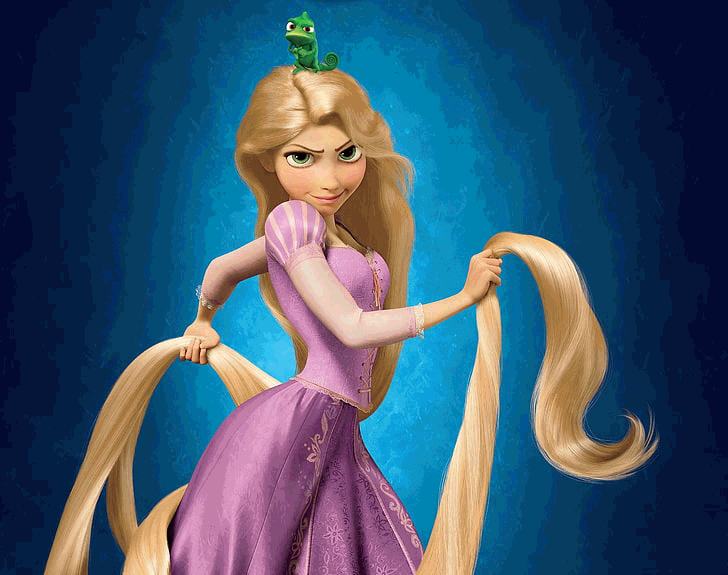

In [14]:
NewImageAtRangeTen


#Observation after quantization at range 10:

# Noticeable false contours detected in blue background, color levels have noticeably decreased 
# Other parts of the image do not seem to be as influenced
# However, cheeks appear to lose color
# Sleeves also seem to lose color
# Slight false contours detected on dress at points where light seems to shine on dress

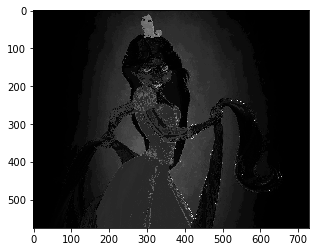

In [15]:
flipNewIndexMapTen =  np.transpose(NewIndexMapTen)
plt.imshow(flipNewIndexMapTen, cmap= "gray")

In [16]:
deleted_twenty, newColorMap_twenty = QuantizationLevels(colorMap, 20)
print(newColorMap_twenty, deleted_twenty, "\n")
NewIndexMapTwenty = AdjustIndex(DataMatrix, deleted_twenty)
print(NewIndexMapTwenty, "\n")
ReversedMapTwenty = ReverseColorMap(newColorMap_twenty)
print(ReversedMapTwenty, "\n")
NewImageAtRangeTwenty = ColorMapToImage(NewIndexMapTwenty, newColorMap_twenty)

{(2, 10, 49): 1, (3, 31, 68): 64, (29, 36, 55): 318, (51, 49, 62): 320, (74, 64, 62): 331, (104, 85, 70): 332, (139, 113, 90): 333, (170, 136, 108): 334, (185, 139, 87): 347, (73, 74, 92): 366, (118, 107, 103): 368, (189, 130, 60): 373, (42, 34, 31): 409, (79, 61, 41): 410, (3, 44, 96): 483, (168, 119, 63): 497, (201, 157, 108): 632, (217, 174, 129): 863, (26, 47, 78): 1079, (47, 63, 88): 1080, (225, 190, 150): 1118, (143, 102, 50): 1445, (164, 130, 85): 1614, (243, 207, 171): 1957, (93, 99, 111): 2085, (120, 78, 40): 2345, (25, 58, 99): 2364, (179, 151, 130): 3162, (147, 133, 122): 3171, (41, 80, 113): 3495, (217, 200, 174): 3548, (193, 178, 155): 3549, (250, 223, 193): 3709, (48, 91, 136): 3767, (141, 140, 146): 3806, (3, 66, 107): 5500, (242, 188, 128): 5861, (222, 162, 100): 6027, (162, 155, 173): 6044, (7, 69, 128): 6374, (246, 210, 150): 7232, (27, 95, 142): 7238, (214, 153, 72): 7886, (112, 123, 125): 8043, (180, 180, 182): 8619, (255, 245, 218): 8692, (6, 100, 138): 9288, (221,

[[ 1.  1.  1. ... 64. 64. 64.]
 [ 1.  1.  1. ... 64. 64. 64.]
 [ 1.  1.  1. ... 64. 64. 64.]
 ...
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]] 

{1: (2, 10, 49), 64: (3, 31, 68), 318: (29, 36, 55), 320: (51, 49, 62), 331: (74, 64, 62), 332: (104, 85, 70), 333: (139, 113, 90), 334: (170, 136, 108), 347: (185, 139, 87), 366: (73, 74, 92), 368: (118, 107, 103), 373: (189, 130, 60), 409: (42, 34, 31), 410: (79, 61, 41), 483: (3, 44, 96), 497: (168, 119, 63), 632: (201, 157, 108), 863: (217, 174, 129), 1079: (26, 47, 78), 1080: (47, 63, 88), 1118: (225, 190, 150), 1445: (143, 102, 50), 1614: (164, 130, 85), 1957: (243, 207, 171), 2085: (93, 99, 111), 2345: (120, 78, 40), 2364: (25, 58, 99), 3162: (179, 151, 130), 3171: (147, 133, 122), 3495: (41, 80, 113), 3548: (217, 200, 174), 3549: (193, 178, 155), 3709: (250, 223, 193), 3767: (48, 91, 136), 3806: (141, 140, 146), 5500: (3, 66, 107), 5861: (242, 188, 128), 6027: (222, 162, 100), 6044: (162

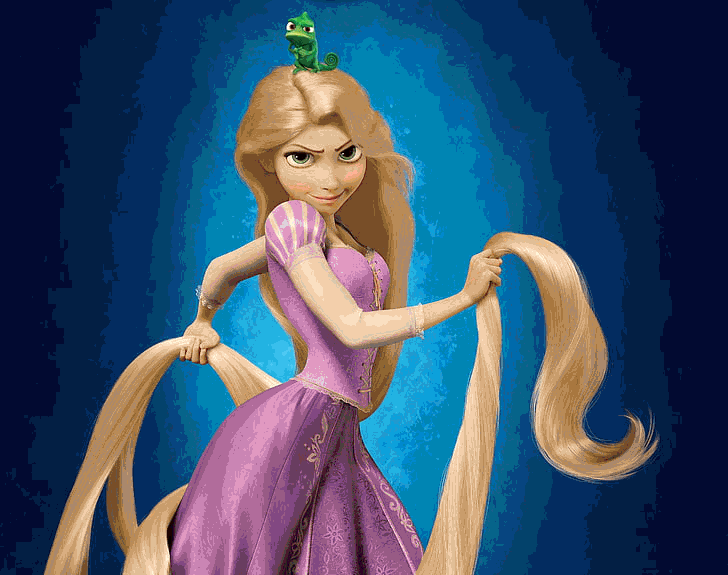

In [17]:
NewImageAtRangeTwenty



# Observation after quantization at range 20:

# Blue background is even more noticeably quantized with less false contours and less color levels
# Gold color appears to be quantized, especially noticeable in shadow caused by hair near the head
# Upper half of dress begins to blend into similar shades of purple
# False contours where light hits the dress become more noticeable
# Shadow softness is noticeably reduced
# Color levels in face are significantly reduced
# Green chameleon still does not appear to be affected as much as rest of the image

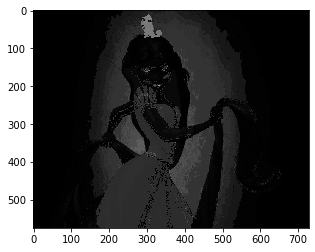

In [18]:
flipNewIndexMapTwenty =  np.transpose(NewIndexMapTwenty)
plt.imshow(flipNewIndexMapTwenty, cmap= "gray")

In [19]:
deleted_thirty, newColorMap_thirty = QuantizationLevels(colorMap, 30)
print(newColorMap_thirty, deleted_thirty, "\n")
NewIndexMapThirty = AdjustIndex(DataMatrix, deleted_thirty)
print(NewIndexMapThirty, "\n")
ReversedMapThirty = ReverseColorMap(newColorMap_thirty)
print(ReversedMapThirty, "\n")
NewImageAtRangeThirty = ColorMapToImage(NewIndexMapThirty, newColorMap_thirty)

{(2, 10, 49): 1, (6, 42, 78): 262, (41, 43, 58): 319, (74, 64, 62): 331, (139, 113, 90): 333, (170, 136, 108): 334, (177, 126, 69): 348, (91, 88, 97): 367, (201, 157, 108): 632, (226, 183, 140): 958, (59, 74, 93): 1081, (143, 102, 50): 1445, (243, 207, 171): 1957, (106, 85, 66): 2189, (113, 71, 33): 2347, (25, 68, 113): 2465, (186, 159, 140): 3164, (155, 146, 141): 3636, (60, 96, 132): 3664, (207, 201, 189): 3805, (178, 169, 174): 3921, (74, 49, 27): 4533, (214, 153, 72): 7886, (112, 123, 125): 8043, (249, 232, 202): 8352, (0, 87, 147): 8896, (234, 182, 109): 9597, (44, 17, 0): 10016, (119, 144, 166): 10073, (12, 0, 8): 10143, (47, 3, 38): 10397, (130, 72, 130): 10510, (107, 44, 97): 10515, (82, 21, 63): 10523, (163, 97, 143): 10730, (195, 127, 168): 10848, (227, 160, 201): 11351, (107, 34, 15): 11753, (0, 120, 153): 11875, (32, 126, 164): 12241, (139, 82, 99): 12381, (145, 183, 194): 12790, (0, 137, 206): 12945, (73, 158, 199): 13287, (68, 133, 153): 13308, (182, 219, 246): 13400, (11

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]] 

{1: (2, 10, 49), 262: (6, 42, 78), 319: (41, 43, 58), 331: (74, 64, 62), 333: (139, 113, 90), 334: (170, 136, 108), 348: (177, 126, 69), 367: (91, 88, 97), 632: (201, 157, 108), 958: (226, 183, 140), 1081: (59, 74, 93), 1445: (143, 102, 50), 1957: (243, 207, 171), 2189: (106, 85, 66), 2347: (113, 71, 33), 2465: (25, 68, 113), 3164: (186, 159, 140), 3636: (155, 146, 141), 3664: (60, 96, 132), 3805: (207, 201, 189), 3921: (178, 169, 174), 4533: (74, 49, 27), 7886: (214, 153, 72), 8043: (112, 123, 125), 8352: (249, 232, 202), 8896: (0, 87, 147), 9597: (234, 182, 109), 10016: (44, 17, 0), 10073: (119, 144, 166), 10143: (12, 0, 8), 10397: (47, 3, 38), 10510: (130, 72, 130), 10515: (107, 44, 97), 10523: (82, 21, 63), 10730: (163, 97, 143), 10848: (195, 127, 168), 11351: (227, 160, 201), 11753: (107, 34, 15), 11875: (0, 120, 153), 12241:

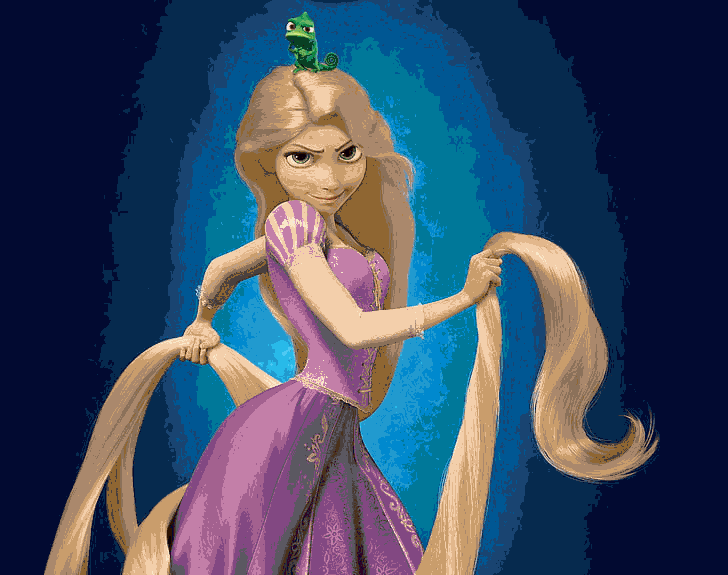

In [20]:
NewImageAtRangeThirty

#NewImageAtRangeThirty.save("Output_At_Range_31.jpg")
# Observation at range 30:

# Skin becomes extremely paler
# Green in eyes is nearly lost
# Blue background now contains very few color levels
# False contours present in hair
# Upper dress appears to blend even further into fewer shades of purple
# Sleeves almost blend into skin
# Noticeable false contours located in lower half of dress, most prominent in areas where light shines off
# dress
# Shadow softness severely deteriorated
# Edge on shoulder band is almost lost
# Chameleon still does not seem to lose as much as color as rest of image, however color loss is 
# much more obvious at range 30

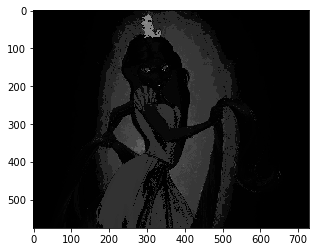

In [21]:
flipNewIndexMapThirty =  np.transpose(NewIndexMapThirty)
plt.imshow(flipNewIndexMapThirty, cmap= "gray")